# Climate Analysis

In [19]:
# Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.sql import func
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date, timedelta
import pandas as pd
from pandas import DataFrame

In [20]:
# Create engine & connection
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)
conn = engine.connect()

In [3]:
# Create automap
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station

In [4]:
# Start a session to query the database
session = Session(engine)

## Precipitation Analysis

In [5]:
# Getting a list of dates for the last 12 months
base_date = datetime.datetime.strptime("2017-08-23", "%Y-%m-%d")
numdays = 365
date_list = [base_date - datetime.timedelta(days=x) for x in range(0, numdays)]

# Converting them to a list of strings
str_dates = []
for date in date_list:
    new_date = date.strftime("%Y-%m-%d")
    str_dates.append(new_date)

In [6]:
# Getting precipitation data
prcp_results = session.query(func.avg(Measurement.prcp), Measurement.date)\
               .filter(Measurement.date.in_(str_dates))\
               .group_by(Measurement.date)

# Converting to a list
prcp_data = []
for res in prcp_results:
    prcp_data.append(res[0])

In [7]:
# Loading the results into a DataFrame
prcp_df = pd.DataFrame([str_dates[::-1], prcp_data[::-1]]).T
prcp_df.rename(columns={0: "Date", 1: "Precipitation"}, inplace=True)
prcp_df.set_index("Date", inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-08-24,0.1325
2016-08-25,0.166667
2016-08-26,0.145
2016-08-27,0.00333333
2016-08-28,0.0225


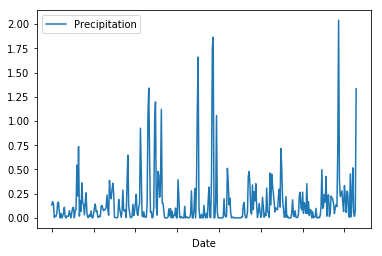

In [8]:
# Plotting data
prcp_df.plot()
plt.savefig("Images/precipitation_analysis.png")
plt.show()

In [9]:
# Summary statistics
prcp_df["Precipitation"].describe()

count     365.0
unique    234.0
top         0.0
freq       48.0
Name: Precipitation, dtype: float64

## Station Analysis

In [11]:
# Count the number of stations
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(9)

In [13]:
# Query to find observation counts by station
obs_counts = session.query(Measurement.station, func.count(Measurement.prcp))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.prcp).desc())

# Printing observations
for station in obs_counts:
    print(station)
    
# Storing station name
top_station = obs_counts[0][0]

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Query to get last 12 months of tobs from top station
tobs_results = session.query(Measurement.tobs)\
               .filter(Measurement.date.in_(str_dates))\
               .filter(Measurement.station == top_station)
        
# Converting to a list
tobs_data = []
for row in tobs_results:
    tobs_data.append(row[0])

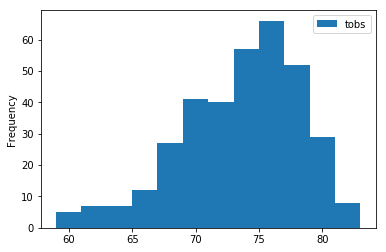

In [15]:
# Plotting histogram
plt.hist(tobs_data, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend()
plt.savefig("Images/station_analysis.png")
plt.show()

## Temperature Analysis

In [16]:
# Defining function calc_temps
def calc_temps (start_date, end_date):
    
    # Converting to date time
    startDate = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    startDate = startDate.replace(startDate.year - 1)
    endDate = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    endDate = endDate.replace(endDate.year - 1)
   
    
    # Getting date range
    delta = endDate - startDate
    date_range = []
    for i in range(delta.days + 1):
        date_range.append(startDate + timedelta(days=i))
        
    # Converting to strings to filter
    str_date_range = []
    for date in date_range:
        new_date = date.strftime("%Y-%m-%d")
        str_date_range.append(new_date)
        
    # Grabbing avg, min & max temps    
    temp_avg = session.query(func.avg(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
    temp_min = session.query(func.min(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
    temp_max = session.query(func.max(Measurement.tobs))\
               .filter(Measurement.date.in_(str_date_range))[0][0]
        
    return temp_avg, temp_min, temp_max

In [17]:
# Calling function
temp_analysis = calc_temps("2016-05-06", "2016-05-12")

# Creating variables
tavg = temp_analysis[0]
tmin = temp_analysis[1]
tmax = temp_analysis[2]

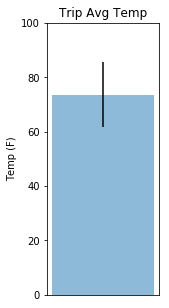

In [18]:
# Plotting bar
plt.figure(figsize=(2,5))
plt.bar(1,height=tavg, yerr=(tmax-tmin), width=0.0001, alpha=0.5)
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.savefig("Images/temperature_analysis.png")
plt.show()